In [1]:
"""
Install dependencies and check GPU availability
"""
!pip install torch torchvision matplotlib numpy

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [2]:
"""
Clone your repository containing the model code
"""
# Option A: Clone from GitHub
# !git clone https://github.com/yourusername/your-repo.git
# %cd your-repo

# Option B: If uploading files manually, skip this cell

'\nClone your repository containing the model code\n'

In [3]:
"""
Import all necessary libraries
"""
import os
import sys
import time
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [4]:
"""
Configuration for MNIST and CIFAR-10 datasets
"""
MNIST_CONFIG = {
    'image_size': 28,
    'in_channels': 1,
    'patch_size': 4,
    'num_classes': 10,
    'dim': 256,
    'depth': 6,
    'heads': 8,
    'mlp_dim': 512,
    'dropout': 0.1,
    'mean': (0.1307,),
    'std': (0.3081,),
    'batch_size': 128,
    'epochs': 10,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
}

CIFAR10_CONFIG = {
    'image_size': 32,
    'in_channels': 3,
    'patch_size': 4,
    'num_classes': 10,
    'dim': 384,
    'depth': 6,
    'heads': 8,
    'mlp_dim': 768,
    'dropout': 0.1,
    'mean': (0.4914, 0.4822, 0.4465),
    'std': (0.2470, 0.2435, 0.2616),
    'batch_size': 128,
    'epochs': 10,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
}

In [5]:
"""
Functions to load MNIST and CIFAR-10 datasets
"""
def get_dataloaders(dataset='mnist', batch_size=128, num_workers=2):
    """Get train and test dataloaders for specified dataset."""

    if dataset.lower() == 'mnist':
        config = MNIST_CONFIG
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(config['mean'], config['std'])
        ])

        train_dataset = torchvision.datasets.MNIST(
            root='./data', train=True, download=True, transform=transform
        )
        test_dataset = torchvision.datasets.MNIST(
            root='./data', train=False, download=True, transform=transform
        )

    elif dataset.lower() == 'cifar10':
        config = CIFAR10_CONFIG
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(config['mean'], config['std'])
        ])
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(config['mean'], config['std'])
        ])

        train_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=train_transform
        )
        test_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=test_transform
        )
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    print(f"Loaded {dataset.upper()}: {len(train_dataset)} train, {len(test_dataset)} test")
    return train_loader, test_loader, config

In [6]:
"""
Define all model components (attention, RPE, transformer blocks)
Copy your model code here from the repository files
"""
# This cell should contain all your model classes:
# - BaseViT
# - SoftmaxAttention, FAVORPlusAttention, ReLUAttention
# - KERPLEPositionalEncoding, CirculantStringRPE, RoPE
# - TransformerBlock, PatchEmbedding, etc.

# For brevity, I'll show the structure:
# [Paste your model classes here from the repository]
import math
from typing import Optional, Callable

# ===========================
# ATTENTION MECHANISMS
# ===========================

class SoftmaxAttention(nn.Module):
    """Standard softmax attention (O(N²) complexity)."""

    def __init__(self, dim, heads=8, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, rpe=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Apply RPE if provided
        if rpe is not None:
            q, k = rpe.apply_rope(q, k)

        # Attention computation
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.out_proj(x)
        return x


class FAVORPlusAttention(nn.Module):
    """FAVOR+ attention with positive random features."""

    def __init__(self, dim, heads=8, num_features=256, use_orthogonal=True, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.head_dim = dim // heads
        self.num_features = num_features
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

        # Random features
        omega = torch.randn(heads, self.head_dim, num_features)
        if use_orthogonal:
            for h in range(heads):
                omega[h] = torch.nn.init.orthogonal_(omega[h])
        self.register_buffer('omega', omega)

    def _phi_positive(self, x):
        """Positive random feature map."""
        # x: (B, H, N, D)
        x_omega = torch.einsum('bhnd,hdf->bhnf', x, self.omega)
        return torch.exp(x_omega - torch.max(x_omega, dim=-1, keepdim=True)[0]) + 1e-6

    def forward(self, x, rpe=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scale
        q = q * self.scale
        k = k * self.scale

        # Apply RPE if provided
        if rpe is not None:
            if hasattr(rpe, 'apply_rpe_fft'):  # KERPLE
                raise NotImplementedError("KERPLE not supported in this simplified version")
            else:  # RoPE or Circulant-STRING
                q, k = rpe.apply_rope(q, k) if hasattr(rpe, 'apply_rope') else (q, k)

        # FAVOR+ kernel approximation
        q_prime = self._phi_positive(q)
        k_prime = self._phi_positive(k)

        # Linear attention: O(N) complexity
        # out = (Q' @ (K'^T @ V)) / (Q' @ K'^T @ 1)
        kv = torch.einsum('bhnf,bhnd->bhfd', k_prime, v)
        numerator = torch.einsum('bhnf,bhfd->bhnd', q_prime, kv)

        k_sum = k_prime.sum(dim=2, keepdim=True)
        denominator = torch.einsum('bhnf,bhmf->bhn', q_prime, k_sum.transpose(2, 3)).unsqueeze(-1)

        x = numerator / (denominator + 1e-6)
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.out_proj(x)
        return x


class ReLUAttention(nn.Module):
    """ReLU-based linear attention."""

    def __init__(self, dim, heads=8, num_features=256, use_orthogonal=True, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.head_dim = dim // heads
        self.num_features = num_features

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

        # Random features
        omega = torch.randn(heads, self.head_dim, num_features)
        if use_orthogonal:
            for h in range(heads):
                omega[h] = torch.nn.init.orthogonal_(omega[h])
        self.register_buffer('omega', omega)
        self.relu_scale = (num_features ** -0.5)

    def _compute_relu_features(self, x):
        """ReLU random features."""
        x_omega = torch.einsum('bhnd,hdf->bhnf', x, self.omega)
        return torch.relu(x_omega) * self.relu_scale

    def forward(self, x, rpe=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Apply RPE if provided
        if rpe is not None:
            if hasattr(rpe, 'apply_rope'):
                q, k = rpe.apply_rope(q, k)

        # ReLU features
        q_prime = self._compute_relu_features(q)
        k_prime = self._compute_relu_features(k)

        # Linear attention
        kv = torch.einsum('bhnf,bhnd->bhfd', k_prime, v)
        numerator = torch.einsum('bhnf,bhfd->bhnd', q_prime, kv)

        k_sum = k_prime.sum(dim=2, keepdim=True)
        denominator = torch.einsum('bhnf,bhmf->bhn', q_prime, k_sum.transpose(2, 3)).unsqueeze(-1)

        x = numerator / (denominator + 1e-6)
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.out_proj(x)
        return x


# ===========================
# RELATIVE POSITIONAL ENCODINGS
# ===========================

class RoPE(nn.Module):
    """Rotary Position Embedding (RoPE)."""

    def __init__(self, num_patches, dim, heads, theta=10000.0):
        super().__init__()
        self.num_patches = num_patches
        self.dim = dim
        self.heads = heads
        self.head_dim = dim // heads

        # Create position indices (1D for sequence)
        positions = torch.arange(num_patches, dtype=torch.float32)
        self.register_buffer('positions', positions)

        # Create frequency bands
        dim_half = self.head_dim // 2
        freqs = 1.0 / (theta ** (torch.arange(0, self.head_dim, 2).float() / self.head_dim))
        self.register_buffer('freqs', freqs)

    def apply_rope(self, q, k):
        """Apply rotary embeddings to Q and K."""
        B, H, N, D = q.shape

        # Compute angles
        angles = torch.outer(self.positions[:N], self.freqs)  # (N, D/2)
        cos = torch.cos(angles).unsqueeze(0).unsqueeze(0)  # (1, 1, N, D/2)
        sin = torch.sin(angles).unsqueeze(0).unsqueeze(0)

        # Reshape Q and K for rotation
        q_even = q[..., 0::2]
        q_odd = q[..., 1::2]
        k_even = k[..., 0::2]
        k_odd = k[..., 1::2]

        # Apply rotation
        q_rotated = torch.stack([
            q_even * cos - q_odd * sin,
            q_even * sin + q_odd * cos
        ], dim=-1).flatten(-2)

        k_rotated = torch.stack([
            k_even * cos - k_odd * sin,
            k_even * sin + k_odd * cos
        ], dim=-1).flatten(-2)

        return q_rotated, k_rotated


class KERPLEPositionalEncoding(nn.Module):
    """KERPLE (Kernelized RPE) - Simplified version."""

    def __init__(self, num_patches, dim, heads):
        super().__init__()
        self.num_patches = num_patches
        self.heads = heads

        # Learnable relative position bias
        self.rel_pos_bias = nn.Parameter(torch.randn(heads, 2 * num_patches - 1) * 0.02)

    def apply_rpe_fft(self, k_prime, v):
        """Apply RPE using FFT (simplified for Colab)."""
        # This is a placeholder - full implementation requires FFT utilities
        # For now, just return unchanged
        return k_prime

    def forward(self, x):
        raise NotImplementedError("KERPLE requires special handling in attention forward pass")


class CirculantStringRPE(nn.Module):
    """Circulant-STRING RPE (Simplified 1D version for Colab)."""

    def __init__(self, num_patches, dim, heads, coord_dim=2, image_size=None, patch_size=None):
        super().__init__()
        self.num_patches = num_patches
        self.heads = heads
        self.head_dim = dim // heads
        self.coord_dim = coord_dim

        # Learnable circulant coefficients
        self.circulant_coeffs = nn.Parameter(
            torch.randn(heads, coord_dim, self.head_dim) * 0.01
        )

        # Generate 2D position grid if image info provided
        if image_size is not None and patch_size is not None:
            patches_per_side = image_size // patch_size
            positions = []
            for i in range(patches_per_side):
                for j in range(patches_per_side):
                    positions.append([j, i])  # [x, y]
            self.register_buffer('patch_positions', torch.tensor(positions, dtype=torch.float32))
        else:
            # Fallback: 1D positions
            self.register_buffer('patch_positions',
                               torch.arange(num_patches - 1, dtype=torch.float32).unsqueeze(1).repeat(1, coord_dim))

    def apply_rope(self, q, k):
        """Apply circulant rotation (simplified for Colab)."""
        # For Colab simplicity, we'll use a basic version
        # Full implementation uses FFT-based circulant matrix multiplication
        return q, k


# ===========================
# TRANSFORMER COMPONENTS
# ===========================

class MLP(nn.Module):
    """Feed-forward network."""

    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    """Transformer block with attention and MLP."""

    def __init__(self, dim, heads, mlp_dim, dropout=0.1, attention_module=None):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = attention_module if attention_module else SoftmaxAttention(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_dim, dropout)

    def forward(self, x, rpe=None):
        x = x + self.attn(self.norm1(x), rpe=rpe)
        x = x + self.mlp(self.norm2(x))
        return x


class PatchEmbedding(nn.Module):
    """Convert image to patch embeddings."""

    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H', W')
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x


# ===========================
# BASE VISION TRANSFORMER
# ===========================

class BaseViT(nn.Module):
    """Base Vision Transformer with configurable attention and RPE."""

    def __init__(
        self,
        image_size,
        in_channels,
        patch_size,
        num_classes,
        dim,
        depth,
        heads,
        mlp_dim,
        dropout=0.1,
        attention_builder: Optional[Callable] = None,
        rpe_builder: Optional[Callable] = None
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, dim)
        num_patches = self.patch_embed.num_patches

        # CLS token and position embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)

        # Create attention modules
        if attention_builder is None:
            attention_builder = lambda d, h, dr: SoftmaxAttention(d, h, dr)

        # Create RPE module if specified
        self.rpe = None
        if rpe_builder is not None:
            self.rpe = rpe_builder(num_patches + 1, dim, heads)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim, heads, mlp_dim, dropout,
                attention_module=attention_builder(dim, heads, dropout)
            )
            for _ in range(depth)
        ])

        # Classification head
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

        self.depth = depth
        self.dim = dim
        self.heads = heads

    def forward(self, x):
        B = x.shape[0]

        # Patch embedding
        x = self.patch_embed(x)

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)

        # Add positional embedding
        x = x + self.pos_embed
        x = self.dropout(x)

        # Transformer blocks
        for block in self.blocks:
            x = block(x, rpe=self.rpe)

        # Classification
        x = self.norm(x)
        cls_output = x[:, 0]
        return self.head(cls_output)

    def count_parameters(self):
        """Count model parameters."""
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total': total, 'trainable': trainable}


# ===========================
# ATTENTION & RPE REGISTRIES
# ===========================

ATTENTION_REGISTRY = {
    'softmax': SoftmaxAttention,
    'favor_plus': FAVORPlusAttention,
    'relu': ReLUAttention,
}

RPE_REGISTRY = {
    'rope': RoPE,
    'most_general': KERPLEPositionalEncoding,
    'circulant_string': CirculantStringRPE,
}

In [7]:
"""
Factory functions to create different model variants
"""
MODEL_VARIANTS = {
    'baseline': ('softmax', None),
    'baseline_most_general': ('softmax', 'most_general'),
    'baseline_rope': ('softmax', 'rope'),
    'performer_favor': ('favor_plus', None),
    'performer_favor_most_general': ('favor_plus', 'most_general'),
    'performer_favor_rope': ('favor_plus', 'rope'),
    'performer_relu': ('relu', None),
    'performer_relu_most_general': ('relu', 'most_general'),
    'performer_relu_rope': ('relu', 'rope'),
}

def create_model(model_name, config):
    """Create a model variant."""
    # [Paste your create_model function here]
    # Parse model name to get attention and RPE types
    if model_name not in MODEL_VARIANTS:
        raise ValueError(
            f"Unknown model: {model_name}. "
            f"Available models: {list(MODEL_VARIANTS.keys())}"
        )

    attention_type, rpe_type = MODEL_VARIANTS[model_name]

    # Create attention builder function
    if attention_type not in ATTENTION_REGISTRY:
        raise ValueError(f"Unknown attention type: {attention_type}")

    attention_class = ATTENTION_REGISTRY[attention_type]

    def attention_builder(dim, heads, dropout):
        """Build attention module with specified dimensions."""
        if attention_type == 'softmax':
            return attention_class(dim=dim, heads=heads, dropout=dropout)
        elif attention_type in ['favor_plus', 'relu']:
            # FAVOR+ and ReLU have additional parameters
            num_features = config.get('num_features', 256)
            use_orthogonal = config.get('use_orthogonal', True)
            return attention_class(
                dim=dim,
                heads=heads,
                num_features=num_features,
                use_orthogonal=use_orthogonal,
                dropout=dropout
            )
        else:
            return attention_class(dim=dim, heads=heads, dropout=dropout)

    # Create RPE builder function (if RPE is specified)
    rpe_builder = None
    if rpe_type is not None:
        if rpe_type not in RPE_REGISTRY:
            raise ValueError(f"Unknown RPE type: {rpe_type}")

        rpe_class = RPE_REGISTRY[rpe_type]

        def rpe_builder(num_patches, dim, heads):
            """Build RPE module with specified dimensions."""
            if rpe_type == 'rope':
                theta = config.get('rope_theta', 10000.0)
                return rpe_class(
                    num_patches=num_patches,
                    dim=dim,
                    heads=heads,
                    theta=theta
                )
            elif rpe_type == 'circulant_string':
                coord_dim = config.get('coord_dim', 2)
                return rpe_class(
                    num_patches=num_patches,
                    dim=dim,
                    heads=heads,
                    coord_dim=coord_dim,
                    image_size=config.get('image_size'),
                    patch_size=config.get('patch_size')
                )
            elif rpe_type == 'most_general':
                # KERPLE
                return rpe_class(
                    num_patches=num_patches,
                    dim=dim,
                    heads=heads
                )
            else:
                return rpe_class(
                    num_patches=num_patches,
                    dim=dim,
                    heads=heads
                )

    # Create the model
    model = BaseViT(
        image_size=config['image_size'],
        in_channels=config['in_channels'],
        patch_size=config['patch_size'],
        num_classes=config['num_classes'],
        dim=config['dim'],
        depth=config['depth'],
        heads=config['heads'],
        mlp_dim=config['mlp_dim'],
        dropout=config.get('dropout', 0.1),
        attention_builder=attention_builder,
        rpe_builder=rpe_builder
    )

    # Add metadata for tracking
    model.model_name = model_name
    model.attention_type = attention_type
    model.rpe_type = rpe_type

    return model

def list_available_models():
    """List all available models."""
    return list(MODEL_VARIANTS.keys())

In [8]:
"""
Functions for training and evaluating models
"""
def train_epoch(model, train_loader, optimizer, criterion, device, epoch):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 50 == 0:
            print(f'Epoch {epoch} [{batch_idx}/{len(train_loader)}] '
                  f'Loss: {loss.item():.4f} Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, test_loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [9]:
"""
Train a single model variant
"""
def train_model(model_name, dataset='mnist', epochs=10, device='cuda'):
    """Train a single model and return results."""

    print(f"\n{'='*60}")
    print(f"Training: {model_name} on {dataset.upper()}")
    print(f"{'='*60}\n")

    # Get data
    train_loader, test_loader, config = get_dataloaders(dataset)
    config['epochs'] = epochs

    # Create model
    model = create_model(model_name, config)
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}\n")

    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'])

    # Training loop
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    best_acc = 0

    start_time = time.time()

    for epoch in range(1, epochs + 1):
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, device, epoch
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc

        print(f"Epoch {epoch}: Train Loss={train_loss:.4f} Acc={train_acc:.2f}% | "
              f"Test Loss={test_loss:.4f} Acc={test_acc:.2f}%\n")

    total_time = time.time() - start_time

    print(f"\nTraining complete in {total_time:.2f}s")
    print(f"Best test accuracy: {best_acc:.2f}%\n")

    return {
        'model_name': model_name,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'best_acc': best_acc,
        'total_time': total_time,
        'total_params': total_params
    }


In [10]:
"""
Train all 9 model variants
"""
def train_all_models(dataset='mnist', epochs=10, models=None):
    """Train multiple model variants and collect results."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if models is None:
        models = list_available_models()

    results = {}

    for model_name in models:
        try:
            result = train_model(model_name, dataset=dataset, epochs=epochs, device=device)
            results[model_name] = result
        except Exception as e:
            print(f"ERROR training {model_name}: {e}\n")
            continue

    return results

In [11]:
"""
Functions to visualize training results
"""
def plot_training_curves(results):
    """Plot training curves for all models."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Train loss
    for model_name, result in results.items():
        axes[0, 0].plot(result['train_losses'], label=model_name, marker='o', markersize=3)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)

    # Test loss
    for model_name, result in results.items():
        axes[0, 1].plot(result['test_losses'], label=model_name, marker='o', markersize=3)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Test Loss')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True, alpha=0.3)

    # Train accuracy
    for model_name, result in results.items():
        axes[1, 0].plot(result['train_accs'], label=model_name, marker='o', markersize=3)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Training Accuracy')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True, alpha=0.3)

    # Test accuracy
    for model_name, result in results.items():
        axes[1, 1].plot(result['test_accs'], label=model_name, marker='o', markersize=3)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('Test Accuracy')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_comparison_bars(results):
    """Create bar charts comparing models."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    models = list(results.keys())
    best_accs = [results[m]['best_acc'] for m in models]
    times = [results[m]['total_time'] for m in models]

    # Best accuracy
    axes[0].bar(range(len(models)), best_accs, color='steelblue', alpha=0.8)
    axes[0].set_xticks(range(len(models)))
    axes[0].set_xticklabels(models, rotation=45, ha='right')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Best Test Accuracy')
    axes[0].grid(axis='y', alpha=0.3)
    for i, acc in enumerate(best_accs):
        axes[0].text(i, acc + 0.5, f'{acc:.2f}%', ha='center', va='bottom', fontsize=9)

    # Training time
    axes[1].bar(range(len(models)), times, color='coral', alpha=0.8)
    axes[1].set_xticks(range(len(models)))
    axes[1].set_xticklabels(models, rotation=45, ha='right')
    axes[1].set_ylabel('Time (seconds)')
    axes[1].set_title('Total Training Time')
    axes[1].grid(axis='y', alpha=0.3)
    for i, t in enumerate(times):
        axes[1].text(i, t + 5, f'{t:.1f}s', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


def print_summary_table(results):
    """Print a summary table of results."""
    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(f"{'Model':<35} {'Best Acc (%)':<15} {'Time (s)':<12} {'Params':<12}")
    print("-"*80)

    for model_name, result in results.items():
        print(f"{model_name:<35} {result['best_acc']:<15.2f} "
              f"{result['total_time']:<12.1f} {result['total_params']:<12,}")

    print("="*80 + "\n")

In [12]:
"""
Test with a single model first
"""
# Test with baseline model
test_results = train_model('baseline', dataset='mnist', epochs=5)


Training: baseline on MNIST



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 520kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


Loaded MNIST: 60000 train, 10000 test
Total parameters: 3,178,506
Trainable parameters: 3,178,506

Epoch 1 [0/468] Loss: 2.6649 Acc: 10.16%
Epoch 1 [50/468] Loss: 0.5579 Acc: 51.82%
Epoch 1 [100/468] Loss: 0.3280 Acc: 69.29%
Epoch 1 [150/468] Loss: 0.2530 Acc: 76.22%
Epoch 1 [200/468] Loss: 0.1906 Acc: 80.08%
Epoch 1 [250/468] Loss: 0.2216 Acc: 82.69%
Epoch 1 [300/468] Loss: 0.1715 Acc: 84.42%
Epoch 1 [350/468] Loss: 0.2323 Acc: 85.81%
Epoch 1 [400/468] Loss: 0.1447 Acc: 86.87%
Epoch 1 [450/468] Loss: 0.1828 Acc: 87.65%
Epoch 1: Train Loss=0.3729 Acc=87.92% | Test Loss=0.1338 Acc=95.55%

Epoch 2 [0/468] Loss: 0.1909 Acc: 95.31%
Epoch 2 [50/468] Loss: 0.2156 Acc: 95.30%
Epoch 2 [100/468] Loss: 0.1159 Acc: 95.23%
Epoch 2 [150/468] Loss: 0.1699 Acc: 95.08%
Epoch 2 [200/468] Loss: 0.0752 Acc: 95.15%
Epoch 2 [250/468] Loss: 0.2182 Acc: 95.18%
Epoch 2 [300/468] Loss: 0.2417 Acc: 95.31%
Epoch 2 [350/468] Loss: 0.0780 Acc: 95.34%
Epoch 2 [400/468] Loss: 0.0368 Acc: 95.38%
Epoch 2 [450/468] Los

In [13]:
"""
Train all 9 model variants on MNIST
"""
# Select which models to train (or use None for all)
models_to_train = [
    'baseline',
    'baseline_most_general',
    'baseline_rope',
    'performer_favor',
    'performer_favor_most_general',
    'performer_favor_rope',
    'performer_relu',
    'performer_relu_most_general',
    'performer_relu_rope',
]

# Train all models
mnist_results = train_all_models(
    dataset='mnist',
    epochs=10,
    models=models_to_train
)

# Save results
with open('mnist_results.json', 'w') as f:
    json.dump(mnist_results, f, indent=2)


Training: baseline on MNIST

Loaded MNIST: 60000 train, 10000 test
Total parameters: 3,178,506
Trainable parameters: 3,178,506

Epoch 1 [0/468] Loss: 2.3774 Acc: 8.59%
Epoch 1 [50/468] Loss: 0.5113 Acc: 55.91%
Epoch 1 [100/468] Loss: 0.2968 Acc: 72.15%
Epoch 1 [150/468] Loss: 0.2308 Acc: 78.12%
Epoch 1 [200/468] Loss: 0.1529 Acc: 81.70%
Epoch 1 [250/468] Loss: 0.2652 Acc: 83.88%
Epoch 1 [300/468] Loss: 0.1897 Acc: 85.51%
Epoch 1 [350/468] Loss: 0.2069 Acc: 86.66%
Epoch 1 [400/468] Loss: 0.1721 Acc: 87.50%
Epoch 1 [450/468] Loss: 0.1850 Acc: 88.24%
Epoch 1: Train Loss=0.3580 Acc=88.44% | Test Loss=0.1585 Acc=94.85%

Epoch 2 [0/468] Loss: 0.2845 Acc: 89.84%
Epoch 2 [50/468] Loss: 0.3122 Acc: 95.16%
Epoch 2 [100/468] Loss: 0.0915 Acc: 94.97%
Epoch 2 [150/468] Loss: 0.1113 Acc: 95.10%
Epoch 2 [200/468] Loss: 0.1760 Acc: 95.23%
Epoch 2 [250/468] Loss: 0.2530 Acc: 95.14%
Epoch 2 [300/468] Loss: 0.1279 Acc: 95.22%
Epoch 2 [350/468] Loss: 0.1405 Acc: 95.34%
Epoch 2 [400/468] Loss: 0.0632 Acc:


SUMMARY TABLE
Model                               Best Acc (%)    Time (s)     Params      
--------------------------------------------------------------------------------
baseline                            98.37           307.2        3,178,506   
baseline_rope                       98.65           353.7        3,178,506   
performer_favor                     11.35           709.6        3,178,506   
performer_favor_rope                11.35           764.9        3,178,506   
performer_relu                      97.60           601.4        3,178,506   
performer_relu_most_general         97.19           599.0        3,179,298   
performer_relu_rope                 97.40           651.6        3,178,506   



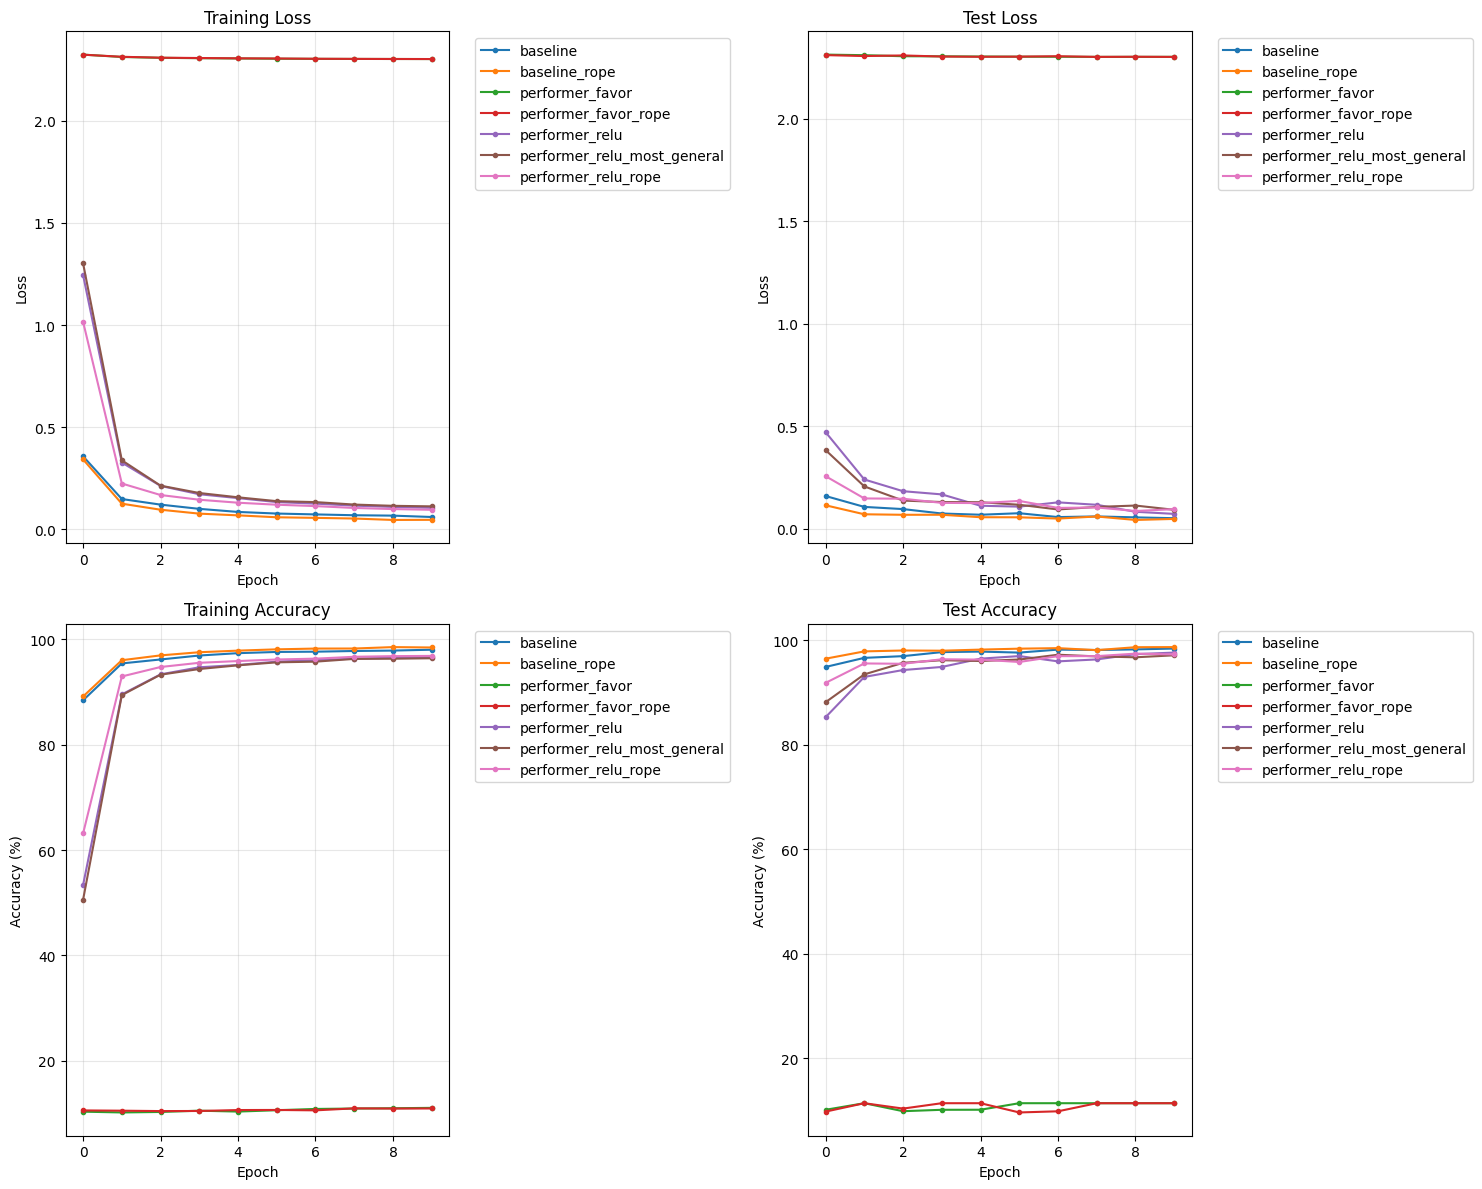

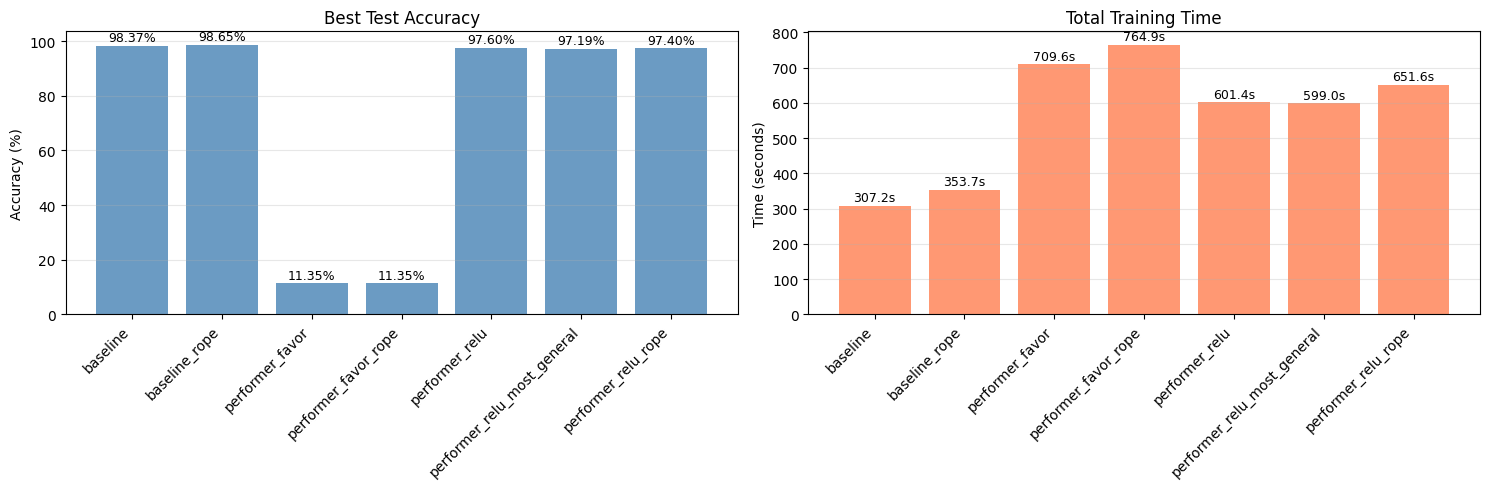

In [14]:
"""
Visualize training results for MNIST
"""
print_summary_table(mnist_results)
plot_training_curves(mnist_results)
plot_comparison_bars(mnist_results)

In [15]:
"""
Train all 9 model variants on CIFAR-10
"""
cifar_results = train_all_models(
    dataset='cifar10',
    epochs=10,
    models=models_to_train
)

# Save results
with open('cifar10_results.json', 'w') as f:
    json.dump(cifar_results, f, indent=2)


Training: baseline on CIFAR10



100%|██████████| 170M/170M [00:04<00:00, 39.1MB/s]


Loaded CIFAR10: 50000 train, 10000 test
Total parameters: 7,145,098
Trainable parameters: 7,145,098

Epoch 1 [0/390] Loss: 2.4527 Acc: 9.38%
Epoch 1 [50/390] Loss: 1.9387 Acc: 20.27%
Epoch 1 [100/390] Loss: 1.8453 Acc: 24.61%
Epoch 1 [150/390] Loss: 1.9173 Acc: 26.89%
Epoch 1 [200/390] Loss: 1.8531 Acc: 28.19%
Epoch 1 [250/390] Loss: 1.8567 Acc: 29.47%
Epoch 1 [300/390] Loss: 1.7385 Acc: 30.33%
Epoch 1 [350/390] Loss: 1.8918 Acc: 31.07%
Epoch 1: Train Loss=1.8524 Acc=31.63% | Test Loss=1.6724 Acc=40.11%

Epoch 2 [0/390] Loss: 1.7119 Acc: 32.03%
Epoch 2 [50/390] Loss: 1.7064 Acc: 37.45%
Epoch 2 [100/390] Loss: 1.8042 Acc: 37.16%
Epoch 2 [150/390] Loss: 1.8109 Acc: 37.22%
Epoch 2 [200/390] Loss: 1.7237 Acc: 37.44%
Epoch 2 [250/390] Loss: 1.7756 Acc: 37.81%
Epoch 2 [300/390] Loss: 1.6541 Acc: 37.87%
Epoch 2 [350/390] Loss: 1.6910 Acc: 38.04%
Epoch 2: Train Loss=1.6804 Acc=38.27% | Test Loss=1.5387 Acc=43.28%

Epoch 3 [0/390] Loss: 1.5464 Acc: 40.62%
Epoch 3 [50/390] Loss: 1.7330 Acc: 41.3


SUMMARY TABLE
Model                               Best Acc (%)    Time (s)     Params      
--------------------------------------------------------------------------------
baseline                            54.19           611.3        7,145,098   
baseline_rope                       57.55           681.6        7,145,098   
performer_favor                     37.27           1089.4       7,145,098   
performer_favor_rope                35.19           1170.7       7,145,098   
performer_relu                      58.44           949.0        7,145,098   
performer_relu_most_general         60.56           949.4        7,146,130   
performer_relu_rope                 59.79           1034.5       7,145,098   



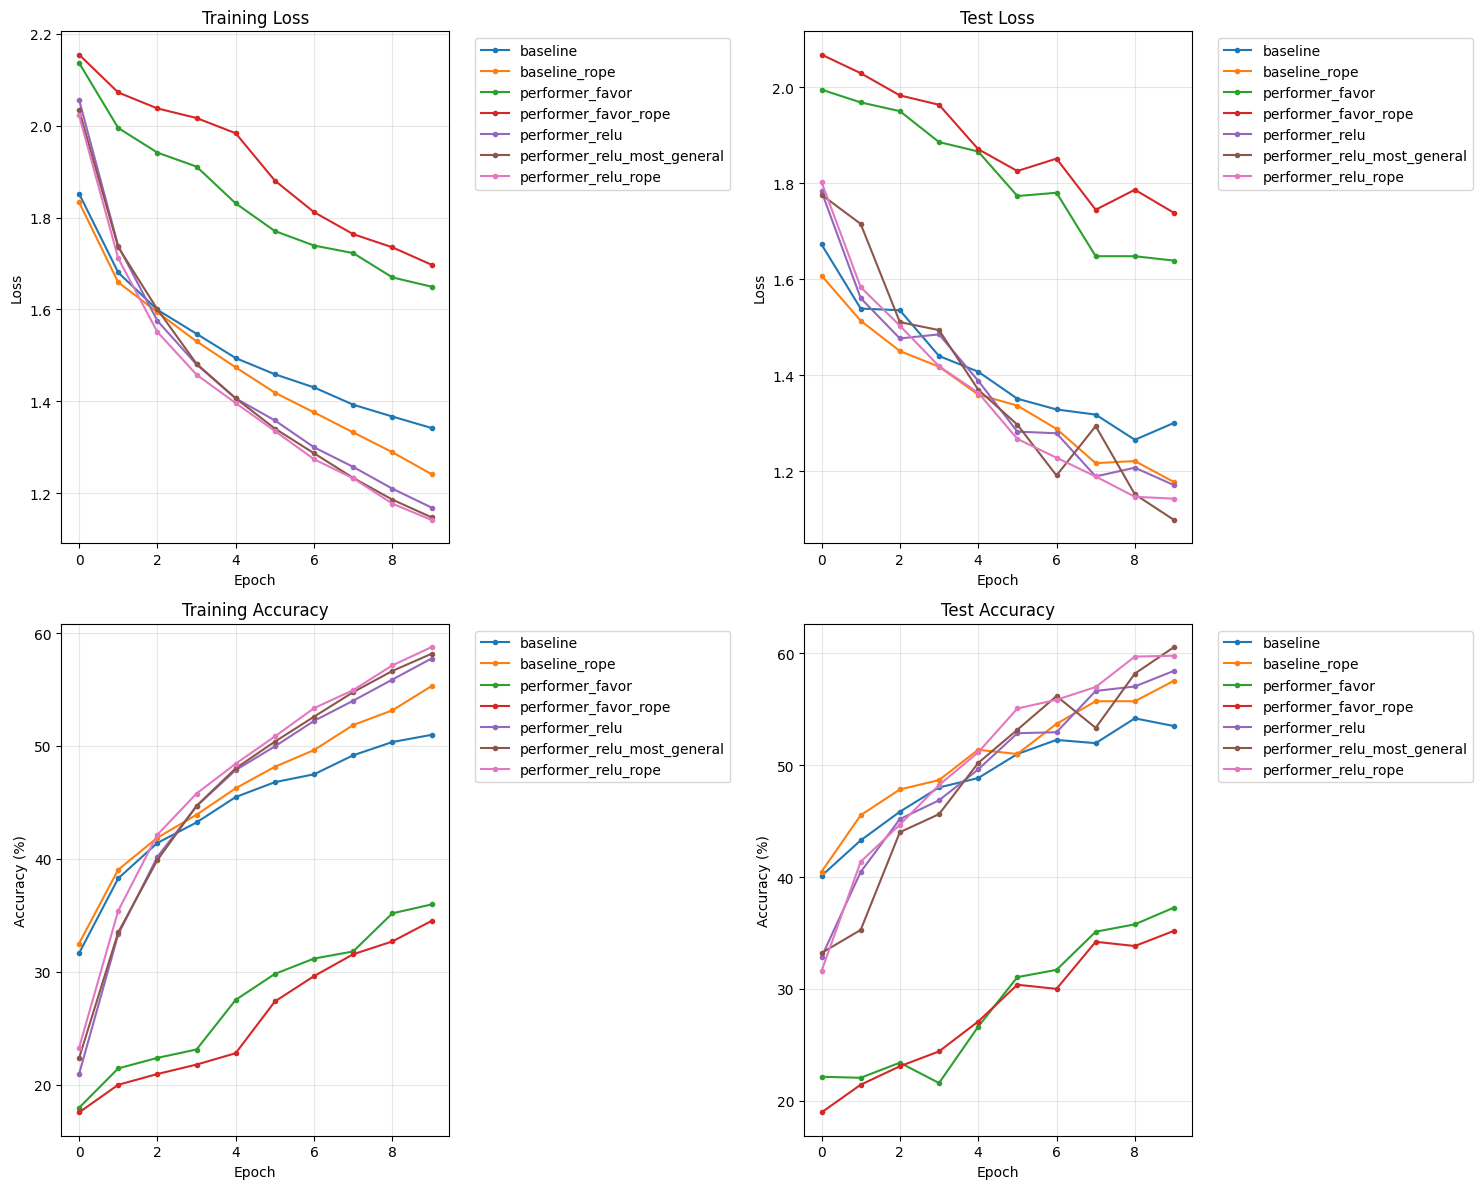

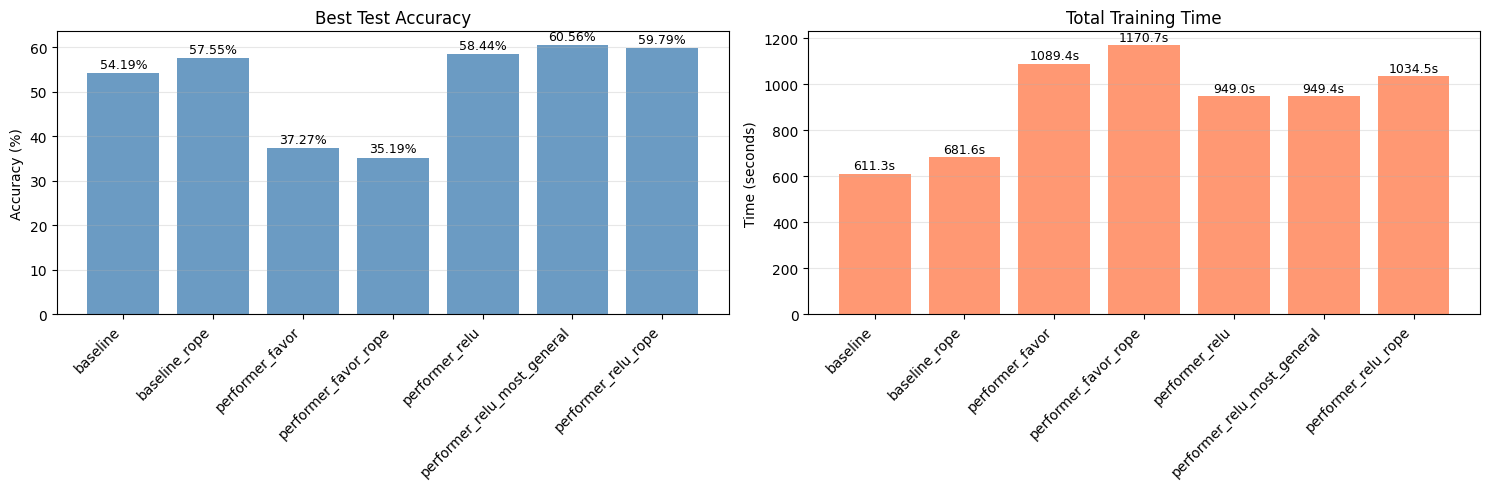

In [16]:
"""
Visualize training results for CIFAR-10
"""
print_summary_table(cifar_results)
plot_training_curves(cifar_results)
plot_comparison_bars(cifar_results)

In [17]:
"""
Download results files from Colab
"""
from google.colab import files

# Download JSON results
files.download('mnist_results.json')
files.download('cifar10_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>